In [80]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()

# Map the problem to a quantum circuit

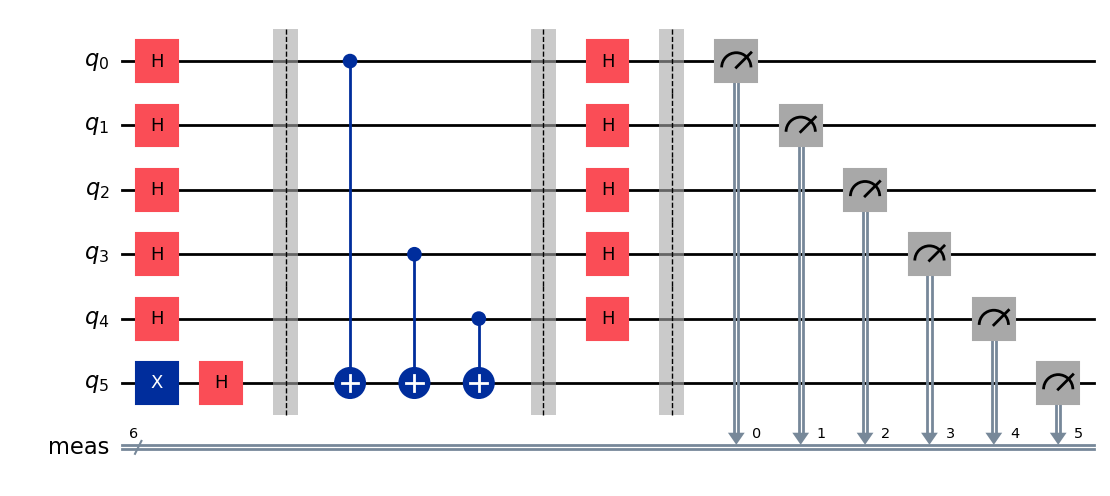

In [108]:
from qiskit import QuantumCircuit
from random import randint
n = 5 # number of bits
qc = QuantumCircuit(n+1) # circuit init with an extra Auxiliary qubit

# initialise Oracle

for i in range(0, n):
    qc.h(i)

def oracle(circuit, n):
    hidden_bits = randint(0,2**n-1) # random n-digit number
    hidden_bits = format(hidden_bits,'0'+str(n)+'b') # binary convert
    circuit.barrier()
    for i in range(n):
        if hidden_bits[i] == '0':
            pass
        elif hidden_bits[i] == '1':
            circuit.cx(i, n)
    circuit.barrier()
    
    return circuit, hidden_bits

qc.x(n)
qc.h(n)

circuit, hidden_bits = oracle(qc, n)

for i in range(n):
    circuit.h(i)

circuit.measure_all()

circuit.draw(output="mpl")

In [109]:
from qiskit.quantum_info import SparsePauliOp
 
# ZZII...II, ZIZI...II, ... , ZIII...IZ
 
operators = SparsePauliOp.from_sparse_list([("ZX", [1, 4], 1), ("YY", [0, 3], 2)], num_qubits=n+1)

# Optimize the problem for execution on quantum hardware

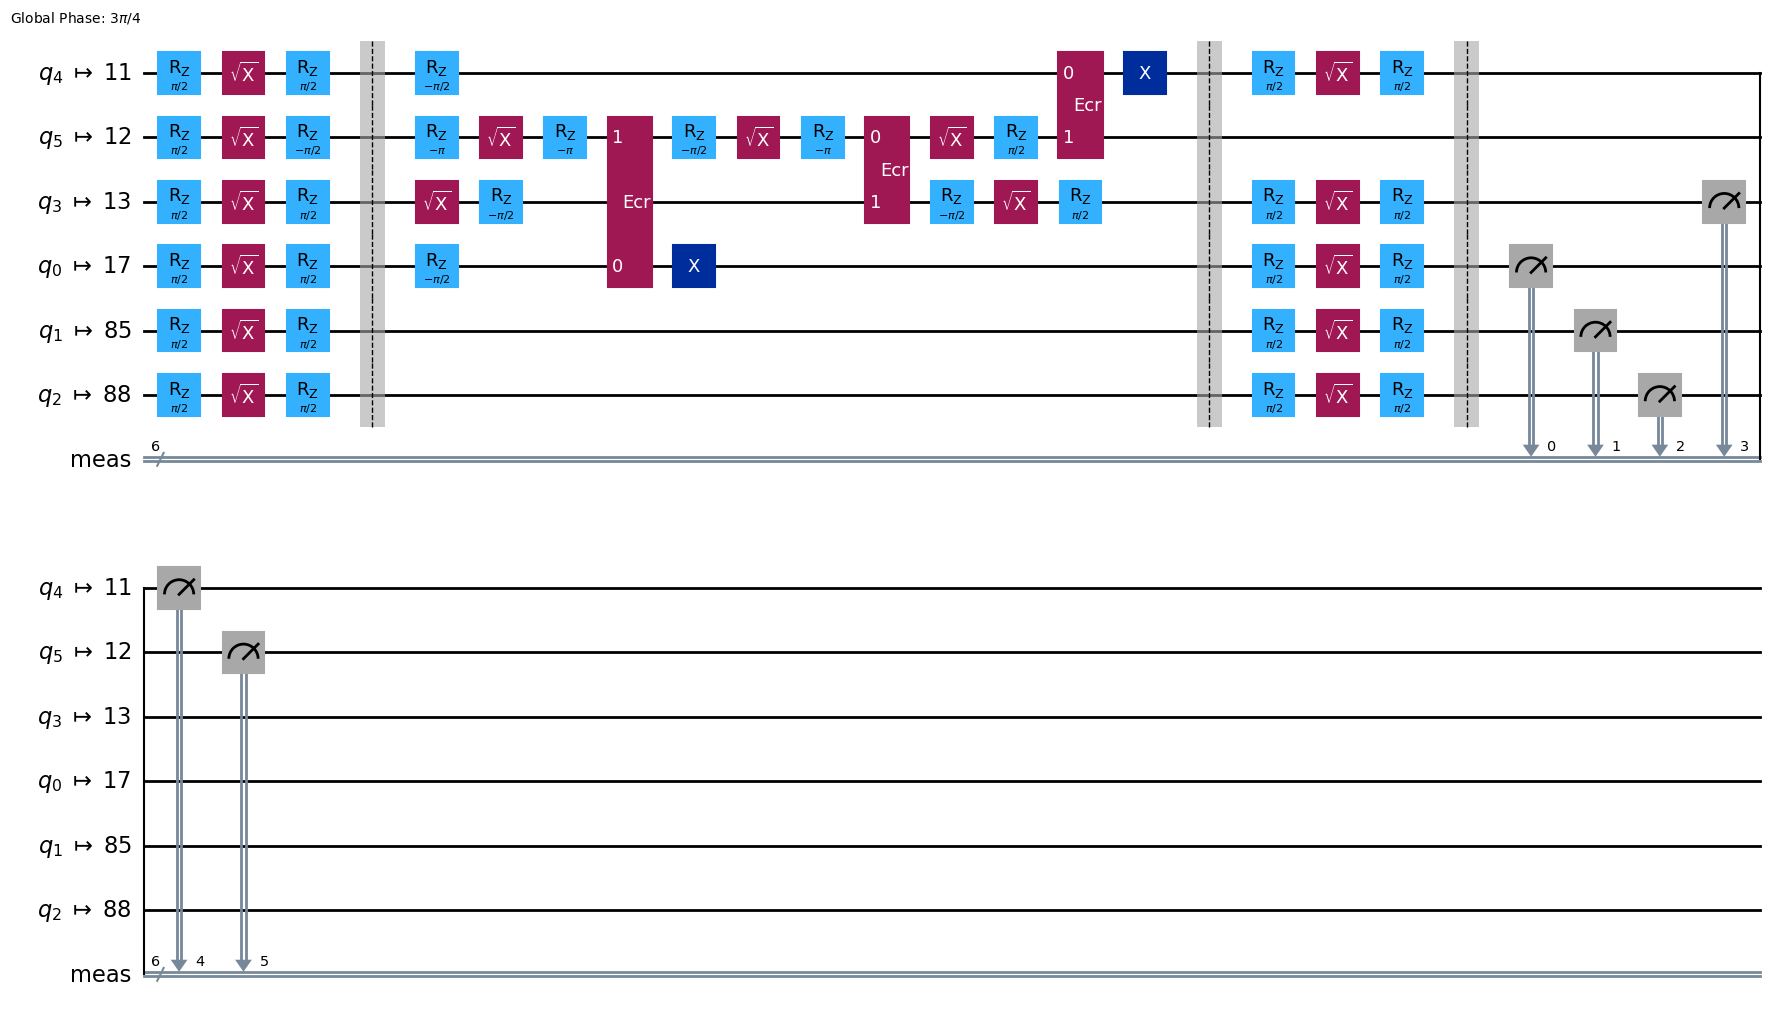

In [110]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2

backend = service.least_busy(simulator=False, operational=True)
# backend = FakeAlmadenV2()

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)

isa_circuit = pm.run(circuit)
isa_operators_list = [op.apply_layout(isa_circuit.layout) for op in operators]

isa_circuit.draw('mpl', idle_wires=False)

In [111]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# Create a Sampler object
sampler = Sampler(mode=backend)
sampler.options.default_shots = 1024

In [112]:
job = sampler.run([isa_circuit])

In [113]:
from qiskit.result import Counts

result = job.result()
dist = result[0].data.meas.get_counts()
counts = Counts(dist)
max_result = max(counts, key=counts.get)
print(max_result[::-1])
print(hidden_bits)

100111
10011


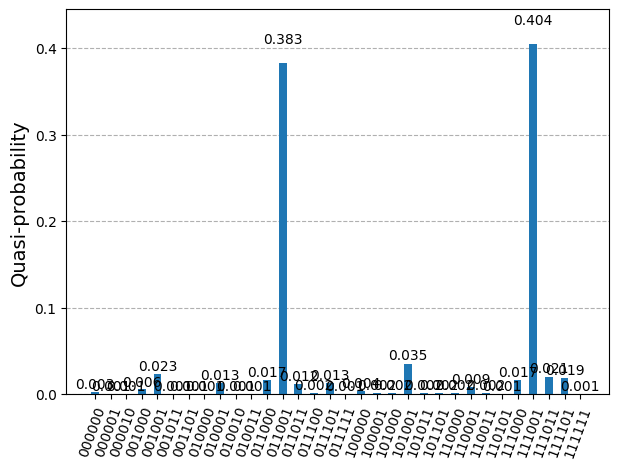

In [114]:
from qiskit.visualization import plot_distribution

plot_distribution(dist)